In [1]:
#Importing the libraries 


import pandas as pd
import numpy as np

In [2]:
df=pd.read_csv('C:\\Users\\OMEN\\Downloads\\covid_19_data.csv')

In [3]:
# Convert date column to datetime
if "ObservationDate" in df.columns:
    df["ObservationDate"] = pd.to_datetime(df["ObservationDate"])
    date_col = "ObservationDate"
elif "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"])
    date_col = "Date"
else:
    raise ValueError("No recognizable date column found!")

In [4]:
# Quick overview
print("🔹 Shape of dataset:", df.shape)
print("\n🔹 Column names:", df.columns.tolist())

print("\n🔹 Data types:")
print(df.dtypes)

🔹 Shape of dataset: (172480, 8)

🔹 Column names: ['SNo', 'ObservationDate', 'Province/State', 'Country/Region', 'Last Update', 'Confirmed', 'Deaths', 'Recovered']

🔹 Data types:
SNo                         int64
ObservationDate    datetime64[ns]
Province/State             object
Country/Region             object
Last Update                object
Confirmed                 float64
Deaths                    float64
Recovered                 float64
dtype: object


In [5]:
print("\n🔹 Missing values per column:")
print(df.isnull().sum())



🔹 Missing values per column:
SNo                    0
ObservationDate        0
Province/State     47886
Country/Region         0
Last Update            0
Confirmed              0
Deaths                 0
Recovered              0
dtype: int64


In [6]:
print("\n🔹 Date range:", df[date_col].min(), "to", df[date_col].max())

# Unique regions
if "Country/Region" in df.columns:
    print("\n🔹 Number of unique countries/regions:", df["Country/Region"].nunique())
    print("Example countries:", df["Country/Region"].unique()[:10])

# Preview data
print("\n🔹 First 5 rows:")
display(df.head())


🔹 Date range: 2020-01-22 00:00:00 to 2020-12-06 00:00:00

🔹 Number of unique countries/regions: 226
Example countries: ['Mainland China' 'Hong Kong' 'Macau' 'Taiwan' 'US' 'Japan' 'Thailand'
 'South Korea' 'Singapore' 'Philippines']

🔹 First 5 rows:


,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,2020-01-22,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,2020-01-22,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,2020-01-22,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,2020-01-22,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,2020-01-22,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [7]:
# Drop unused columns
df = df.drop(columns=["SNo", "Last Update", "Province/State"])

# Convert ObservationDate to datetime
df["ObservationDate"] = pd.to_datetime(df["ObservationDate"])

# Aggregate by Country and Date
df = df.groupby(["Country/Region", "ObservationDate"]).sum().reset_index()

# Sort by Country and Date
df = df.sort_values(by=["Country/Region", "ObservationDate"])

# Quick check
print("Date range:", df["ObservationDate"].min(), "to", df["ObservationDate"].max())
print("Number of unique countries/regions:", df["Country/Region"].nunique())
df.head()

Date range: 2020-01-22 00:00:00 to 2020-12-06 00:00:00
Number of unique countries/regions: 226


,Country/Region,ObservationDate,Confirmed,Deaths,Recovered
0,Azerbaijan,2020-02-28,1.0,0.0,0.0
1,"('St. Martin',)",2020-03-10,2.0,0.0,0.0
2,Afghanistan,2020-02-24,1.0,0.0,0.0
3,Afghanistan,2020-02-25,1.0,0.0,0.0
4,Afghanistan,2020-02-26,1.0,0.0,0.0


In [8]:
# Sort again just to be safe
df = df.sort_values(by=["Country/Region", "ObservationDate"])

# Create lag features (1 day and 7 days ago)
df["Confirmed_lag1"] = df.groupby("Country/Region")["Confirmed"].shift(1)
df["Confirmed_lag7"] = df.groupby("Country/Region")["Confirmed"].shift(7)

# Create rolling mean (7-day average)
df["Confirmed_rolling7"] = df.groupby("Country/Region")["Confirmed"].transform(lambda x: x.rolling(7).mean())

# Drop NA values created by lags
df = df.dropna()

df.head(10)


,Country/Region,ObservationDate,Confirmed,Deaths,Recovered,Confirmed_lag1,Confirmed_lag7,Confirmed_rolling7
9,Afghanistan,2020-03-02,1.0,0.0,0.0,1.0,1.0,1.000000
10,Afghanistan,2020-03-03,2.0,0.0,0.0,1.0,1.0,1.142857
11,Afghanistan,2020-03-04,4.0,0.0,0.0,2.0,1.0,1.571429
12,Afghanistan,2020-03-05,4.0,0.0,0.0,4.0,1.0,2.000000
13,Afghanistan,2020-03-06,4.0,0.0,0.0,4.0,1.0,2.428571
14,Afghanistan,2020-03-07,4.0,0.0,0.0,4.0,1.0,2.857143
15,Afghanistan,2020-03-08,5.0,0.0,0.0,4.0,1.0,3.428571
16,Afghanistan,2020-03-09,7.0,0.0,0.0,5.0,1.0,4.285714
17,Afghanistan,2020-03-10,8.0,0.0,0.0,7.0,2.0,5.142857
18,Afghanistan,2020-03-11,11.0,0.0,0.0,8.0,4.0,6.142857


In [35]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# -----------------------------
# 1. Feature Engineering
# -----------------------------
# Create lag and rolling features per country
df = df.sort_values(["Country/Region", "ObservationDate"])

df["Confirmed_lag1"] = df.groupby("Country/Region")["Confirmed"].shift(1)
df["Confirmed_lag7"] = df.groupby("Country/Region")["Confirmed"].shift(7)
df["Confirmed_rolling7"] = (
    df.groupby("Country/Region")["Confirmed"].shift(1).rolling(7).mean()
)

In [34]:
pip install xgboost


   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   - -------------------------------------- 2.4/56.8 MB 11.5 MB/s eta 0:00:05
   --- ------------------------------------ 4.5/56.8 MB 11.2 MB/s eta 0:00:05
   --- ------------------------------------ 5.2/56.8 MB 11.1 MB/s eta 0:00:05
   ---- ----------------------------------- 6.0/56.8 MB 7.3 MB/s eta 0:00:07
   ----- ---------------------------------- 7.3/56.8 MB 7.2 MB/s eta 0:00:07
   ----- ---------------------------------- 8.1/56.8 MB 6.6 MB/s eta 0:00:08
   ------ --------------------------------- 8.9/56.8 MB 6.3 MB/s eta 0:00:08
   ------- -------------------------------- 10.0/56.8 MB 6.1 MB/s eta 0:00:08
   ------- -------------------------------- 11.0/56.8 MB 6.0 MB/s eta 0:00:08
   -------- ------------------------------- 12.6/56.8 MB 6.1 MB/s eta 0:00:08
   --------- ------------------------------ 14.2/56.8 MB 6.2 MB/s eta 0:00:07
   ---------- ----------------------------- 14.9/56.8 MB 6.0 MB/s eta 0:00:0


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [36]:
# 1. Feature Engineering (Global)
# -----------------------------
df = df.sort_values(["Country/Region", "ObservationDate"])

# Lags & rolling features (per country)
df["Confirmed_lag1"] = df.groupby("Country/Region")["Confirmed"].shift(1)
df["Confirmed_lag7"] = df.groupby("Country/Region")["Confirmed"].shift(7)
df["Confirmed_rolling7"] = (
    df.groupby("Country/Region")["Confirmed"].shift(1).rolling(7).mean()
)


In [37]:
df = df.dropna()

In [38]:
# 2. Train-Test Split (Global)
# -----------------------------
split_date = "2020-10-01"
train = df[df["ObservationDate"] < split_date]
test = df[df["ObservationDate"] >= split_date]

features = ["Confirmed_lag1", "Confirmed_lag7", "Confirmed_rolling7"]
target = "Confirmed"

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (35973, 3) (35973,)
Test shape: (11440, 3) (11440,)


In [40]:
# 3. Random Forest
# -----------------------------


from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

mse = mean_squared_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(mse)
rf_r2 = r2_score(y_test, y_pred_rf)
print(f"Random Forest RMSE: {rf_rmse:.2f}, R²: {rf_r2:.3f}")

Random Forest RMSE: 232706.97, R²: 0.948


In [43]:
import numpy as np
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)



xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

xgb_r2 = r2_score(y_test, y_pred_xgb)
print(f"XGBoost RMSE: {xgb_rmse:.2f}, R²: {xgb_r2:.3f}")


XGBoost RMSE: 247196.14, R²: 0.941


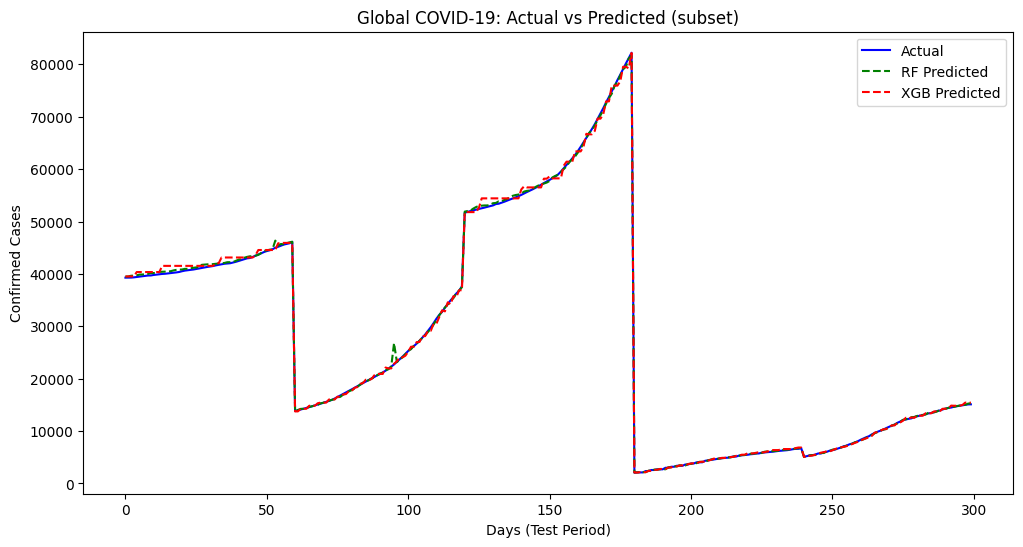

In [44]:
# 5. Compare Predictions
# -----------------------------
plt.figure(figsize=(12,6))
plt.plot(y_test.values[:300], label="Actual", color="blue")   # plot subset for visibility
plt.plot(y_pred_rf[:300], label="RF Predicted", color="green", linestyle="dashed")
plt.plot(y_pred_xgb[:300], label="XGB Predicted", color="red", linestyle="dashed")
plt.title("Global COVID-19: Actual vs Predicted (subset)")
plt.xlabel("Days (Test Period)")
plt.ylabel("Confirmed Cases")
plt.legend()
plt.show()

Hybrid Ensemble RMSE: 236074.94, R²: 0.946
Hybrid Ensemble R²: 0.9462


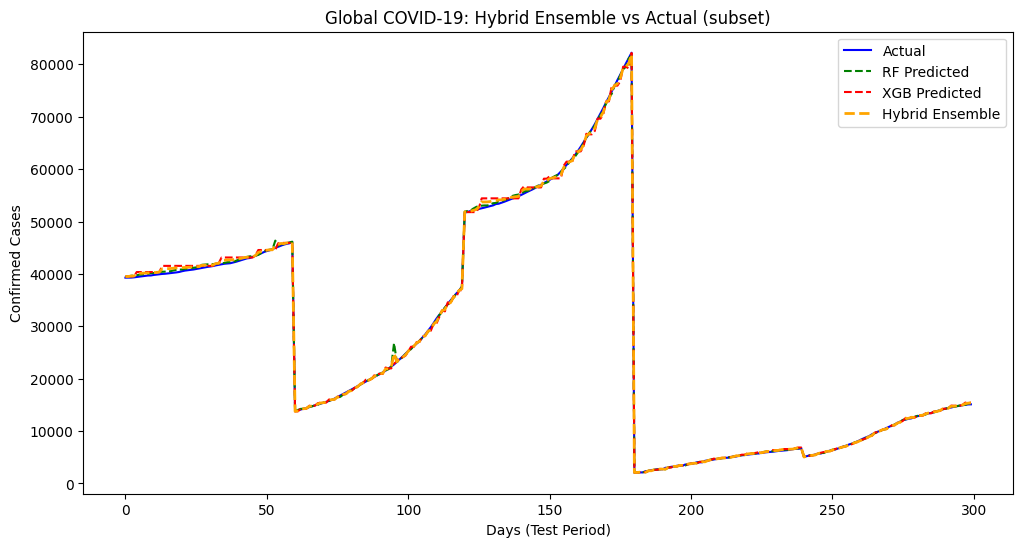

In [46]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# --- Ensemble Predictions (average of RF + XGB) ---
y_pred_ensemble = (y_pred_rf + y_pred_xgb) / 2

# --- Evaluate ---
ensemble_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ensemble))
ensemble_r2 = r2_score(y_test, y_pred_ensemble)

print(f"Hybrid Ensemble RMSE: {ensemble_rmse:.2f}, R²: {ensemble_r2:.3f}")

print(f"Hybrid Ensemble R²: {ensemble_r2:.4f}")

# --- Plot comparison ---
plt.figure(figsize=(12,6))
plt.plot(y_test.values[:300], label="Actual", color="blue")
plt.plot(y_pred_rf[:300], label="RF Predicted", color="green", linestyle="dashed")
plt.plot(y_pred_xgb[:300], label="XGB Predicted", color="red", linestyle="dashed")
plt.plot(y_pred_ensemble[:300], label="Hybrid Ensemble", color="orange", linestyle="dashed", linewidth=2)

plt.title("Global COVID-19: Hybrid Ensemble vs Actual (subset)")
plt.xlabel("Days (Test Period)")
plt.ylabel("Confirmed Cases")
plt.legend()
plt.show()
